In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

tickers = ['SPY', 'QQQ', 'MSFT', 'AAPL', 'AMZN']

end_date = datetime.now()
start_date = end_date - timedelta(days=7) 

try:
    a_data = yf.download(
        tickers=tickers,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval="1m"
    )
    
    if a_data.empty:
        print("Error")
        exit() 
        
    print(a_data.head())

    # data to long
    df = a_data.stack(level=1).reset_index()

    df.rename(columns={
        'level_0': 'Datetime',
        'level_1': 'Ticker',  
        'Adj Close': 'Adj_Close' 
    }, inplace=True)
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

    print("Long data")
    print(df.head(10)) 


except Exception as e:
    print('Error')

/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_46400/3456497280.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  a_data = yf.download(
[*********************100%***********************]  5 of 5 completed

Price                           Close                                      \
Ticker                           AAPL        AMZN        MSFT         QQQ   
Datetime                                                                    
2025-07-17 13:30:00+00:00  210.800003  223.591202  506.880005  558.119995   
2025-07-17 13:31:00+00:00  210.625000  223.649994  507.690002  558.090027   
2025-07-17 13:32:00+00:00  210.729996  223.266098  507.179993  557.590027   
2025-07-17 13:33:00+00:00  210.289993  223.345001  506.829987  557.390015   
2025-07-17 13:34:00+00:00  210.529999  223.399994  506.700012  557.655029   

Price                                        High                          \
Ticker                            SPY        AAPL        AMZN        MSFT   
Datetime                                                                    
2025-07-17 13:30:00+00:00  624.440002  210.910004  223.940002  507.459991   
2025-07-17 13:31:00+00:00  624.719971  210.850006  223.820007  507.690002  


/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_46400/3456497280.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = a_data.stack(level=1).reset_index()


In [3]:

import pandas as pd
import numpy as np

df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

# VOL IMB
df['Close_prev'] = df.groupby('Ticker')['Close'].shift(1)
df['Volume_Imbalance'] = np.where(
    df['Close'] > df['Close_prev'],
    df['Volume'],
    np.where(
        df['Close'] < df['Close_prev'],
        -df['Volume'],
        0
    )
)
df['Volume_Imbalance'] = df['Volume_Imbalance'].fillna(0) 

df_wide = df.pivot_table(
    index='Datetime',
    columns='Ticker',
    values=['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance']
)

if ('Close', 'SPY') in df_wide.columns:
    df_wide[('Close', 'SPY')] = df_wide[('Close', 'SPY')].ffill()
    for col_name in ['Open', 'High', 'Low', 'Volume', 'Volume_Imbalance']: 
        if (col_name, 'SPY') in df_wide.columns:
            df_wide[(col_name, 'SPY')] = df_wide[(col_name, 'SPY')].ffill()

actual_tickers = df['Ticker'].unique()

# LOG RETURN
for ticker_symbol in actual_tickers:
    if ('Close', ticker_symbol) in df_wide.columns:
        df_wide[('Log_Return', ticker_symbol)] = np.log(df_wide['Close'][ticker_symbol] / df_wide['Close'][ticker_symbol].shift(1))
        df_wide[('Log_Return', ticker_symbol)] = df_wide[('Log_Return', ticker_symbol)].fillna(0.0)
    else:
        df_wide[('Log_Return', ticker_symbol)] = np.nan 

#  Corr_SPY
correlation_window = 5

for ticker_symbol in actual_tickers:
    if ticker_symbol == 'SPY':
        df_wide[('Corr_SPY', ticker_symbol)] = 1.0 
    else:
        if ('Log_Return', 'SPY') in df_wide.columns and ('Log_Return', ticker_symbol) in df_wide.columns:
            df_wide[('Corr_SPY', ticker_symbol)] = df_wide['Log_Return']['SPY'].rolling(
                window=correlation_window, min_periods=max(2, correlation_window // 2) 
            ).corr(df_wide['Log_Return'][ticker_symbol])
        else:
            df_wide[('Corr_SPY', ticker_symbol)] = np.nan


for col in df_wide.columns:
    if isinstance(col, tuple) and col[0] == 'Corr_SPY':
        df_wide[col] = df_wide[col].fillna(0.0)

new_columns = []
for col_tuple in df_wide.columns:
    if len(col_tuple) == 2:
        new_columns.append(f"{col_tuple[0]}_{col_tuple[1]}")
    elif len(col_tuple) == 1: 
        new_columns.append(col_tuple[0])
    else: 
        new_columns.append("_".join(col_tuple))
df_wide.columns = new_columns


df_long_final = pd.DataFrame()

for ticker_symbol in actual_tickers:
    base_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance', 'Log_Return']
    cols_to_extract = [f"{col_name}_{ticker_symbol}" for col_name in base_cols]

    corr_col_name_in_df_wide = f'Corr_SPY_{ticker_symbol}'
    if corr_col_name_in_df_wide in df_wide.columns:
        cols_to_extract.append(corr_col_name_in_df_wide)

    existing_cols = [col for col in cols_to_extract if col in df_wide.columns]

    if not existing_cols:
        continue 

    temp_df = df_wide[existing_cols].copy()

    new_temp_df_cols = []
    for col in temp_df.columns:
        if col.startswith('Corr_SPY_'):
            new_temp_df_cols.append('Corr_SPY')
        elif col.endswith(f'_{ticker_symbol}'):
            new_temp_df_cols.append(col.replace(f'_{ticker_symbol}', ''))
        else:
            new_temp_df_cols.append(col)
    temp_df.columns = new_temp_df_cols

    temp_df['Ticker'] = ticker_symbol
    temp_df.reset_index(inplace=True) 
    df_long_final = pd.concat([df_long_final, temp_df], ignore_index=True)

df_long_final.sort_values(by=['Datetime', 'Ticker'], inplace=True)
df_long_final.columns = [col.lower() for col in df_long_final.columns]

print('\n--- df_long_final.head() (final) ---')
print(df_long_final.head(20))

print('\n--- df_long_final.info() ---')
print(df_long_final.info())


--- df_long_final.head() (final) ---
                      datetime        open        high         low  \
0    2025-07-17 13:30:00+00:00  210.625000  210.910004  210.449997   
1950 2025-07-17 13:30:00+00:00  223.320007  223.940002  223.190002   
3900 2025-07-17 13:30:00+00:00  505.679993  507.459991  505.619995   
5850 2025-07-17 13:30:00+00:00  557.984985  558.424988  557.859985   
7800 2025-07-17 13:30:00+00:00  624.400024  624.700012  624.179993   
1    2025-07-17 13:31:00+00:00  210.809998  210.850006  210.460007   
1951 2025-07-17 13:31:00+00:00  223.654999  223.820007  223.520004   
3901 2025-07-17 13:31:00+00:00  506.875000  507.690002  506.394989   
5851 2025-07-17 13:31:00+00:00  558.169983  558.294983  557.784973   
7801 2025-07-17 13:31:00+00:00  624.440002  624.880005  624.429993   
2    2025-07-17 13:32:00+00:00  210.610001  210.919998  210.345001   
1952 2025-07-17 13:32:00+00:00  223.669998  223.889999  223.244995   
3902 2025-07-17 13:32:00+00:00  507.829987  508.2999

Statistical
       volume_imbalance   log_return     corr_spy
count      9.750000e+03  9750.000000  9750.000000
mean       5.415409e+03     0.000006     0.577182
std        1.887405e+05     0.000378     0.458974
min       -3.074698e+06    -0.006196    -1.000000
25%       -5.495975e+04    -0.000143     0.333685
50%        7.484500e+03     0.000004     0.735768
75%        5.976675e+04     0.000157     0.960383
max        6.982345e+06     0.003466     1.000000
Visualize


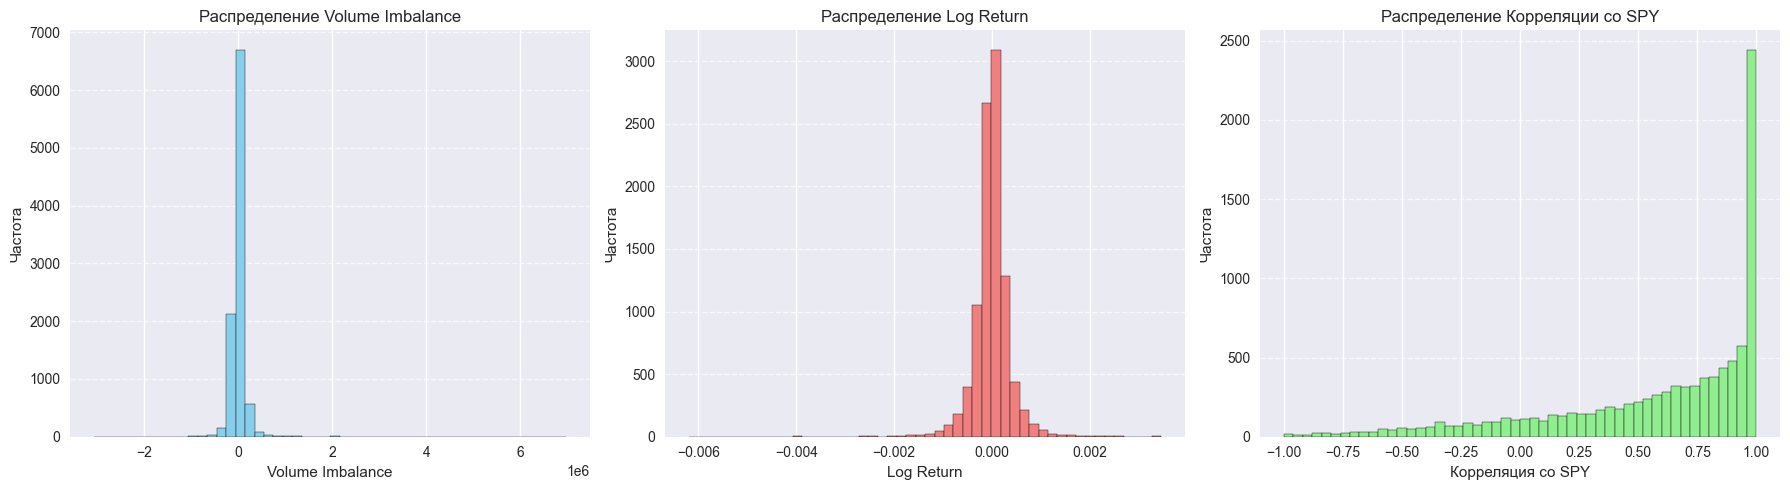

Графики распределений сохранены в 'feature_distributions_your_data.png'
Провожу ADF и ACF тесты для тикера: AAPL

ADF Test для AAPL:
  - close: p-value=0.4166 (Стационарен, если p < 0.05)
  - volume_imbalance: p-value=0.0000 (Стационарен, если p < 0.05)
  - log_return: p-value=0.0000 (Стационарен, если p < 0.05)
  - corr_spy: p-value=0.0000 (Стационарен, если p < 0.05)

Графики автокорреляции (ACF) для AAPL:


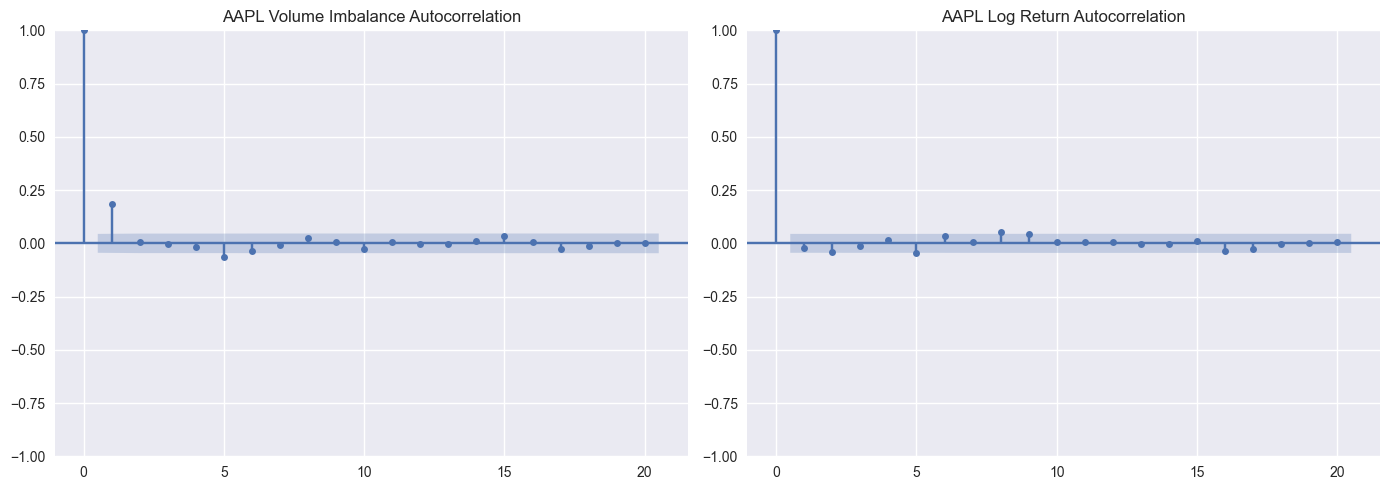

Графики автокорреляции сохранены в 'autocorrelation_plots_your_data.png'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats # For checking z-score or other statistics manually if needed
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Assuming your df_long_final DataFrame is already loaded in your environment.
# Example if loading from a file:
# df_long_final = pd.read_csv('your_data.csv', parse_dates=['datetime'])
# df_long_final['datetime'] = pd.to_datetime(df_long_final['datetime'], utc=True)

# --- 1. Statistical Properties of Key Features ---
print("--- Statistical Properties of Key Features ---")
# Resetting index if 'datetime' is currently the index, to ensure 'ticker' is accessible
df_for_analysis = df_long_final.reset_index()
print(df_for_analysis[['volume_imbalance', 'log_return', 'corr_spy']].describe().to_string())

# --- 2. Visualize Feature Distributions ---
print("\n--- Visualizing Key Feature Distributions ---")
plt.style.use('seaborn-v0_8') # For a more visually appealing style
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram for Volume Imbalance
df_for_analysis['volume_imbalance'].hist(bins=50, ax=axes[0], edgecolor='black', color='skyblue')
axes[0].set_title('Distribution of Volume Imbalance')
axes[0].set_xlabel('Volume Imbalance')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for Log Return
df_for_analysis['log_return'].hist(bins=50, ax=axes[1], edgecolor='black', color='lightcoral')
axes[1].set_title('Distribution of Log Return')
axes[1].set_xlabel('Log Return')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram for Correlation with SPY
df_for_analysis['corr_spy'].hist(bins=50, ax=axes[2], edgecolor='black', color='lightgreen')
axes[2].set_title('Distribution of Correlation with SPY')
axes[2].set_xlabel('Correlation with SPY')
axes[2].set_ylabel('Frequency')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('feature_distributions_your_data.png', dpi=300, bbox_inches='tight')
plt.show()
print("Distribution plots saved to 'feature_distributions_your_data.png'")

# --- 3. Data Quality Checks (ADF Test and ACF Plots) ---
print("\n--- Data Quality Checks (ADF Test and ACF Plots) ---")

# Get unique tickers from the original df_long_final (or df_for_analysis after reset_index)
# Assuming 'ticker' column exists.
if 'ticker' in df_long_final.columns:
    tickers_list = df_long_final['ticker'].unique()
else:
    # If no 'ticker' column, assume it's a single asset and handle appropriately
    print("Warning: 'ticker' column not found. Performing tests on the entire dataset as a single asset.")
    tickers_list = ['Overall_Data'] # Placeholder for a single asset

if len(tickers_list) > 0:
    # Select the first ticker for detailed time series tests (ADF, ACF)
    # If 'Overall_Data', it means tests will run on the full df_for_analysis
    example_ticker_for_tests = tickers_list[0]

    # Prepare DataFrame for time series tests. Ensure datetime is index for these tests.
    if example_ticker_for_tests == 'Overall_Data':
        df_example_ticker = df_for_analysis.set_index('datetime').copy()
    else:
        df_example_ticker = df_for_analysis[df_for_analysis['ticker'] == example_ticker_for_tests].set_index('datetime').copy()

    print(f"Running ADF and ACF tests for ticker: {example_ticker_for_tests}")

    if df_example_ticker.empty:
        print(f"No data available for ticker {example_ticker_for_tests} for tests.")
    else:
        print(f"\nADF Test for {example_ticker_for_tests}:")
        for col in ['close', 'volume_imbalance', 'log_return', 'corr_spy']:
            if col in df_example_ticker.columns and not df_example_ticker[col].dropna().empty:
                try:
                    # ADF test requires at least 2 observations
                    if len(df_example_ticker[col].dropna()) > 2:
                        result = adfuller(df_example_ticker[col].dropna())
                        p_value = result[1]
                        print(f"  - {col}: p-value={p_value:.4f} (Stationary if p < 0.05)")
                    else:
                        print(f"  - {col}: Insufficient data for ADF test (need > 2 observations).")
                except Exception as e:
                    print(f"  - {col}: Error during ADF test calculation: {e}")
            else:
                print(f"  - {col}: Column missing or empty for ADF test.")

        print(f"\nAutocorrelation Function (ACF) Plots for {example_ticker_for_tests}:")
        fig_acf, axes_acf = plt.subplots(1, 2, figsize=(14, 5))

        # ACF requires at least two non-null values
        if len(df_example_ticker['volume_imbalance'].dropna()) > 1:
            plot_acf(df_example_ticker['volume_imbalance'].dropna(), lags=min(len(df_example_ticker['volume_imbalance'].dropna()) - 1, 20), ax=axes_acf[0], title=f'{example_ticker_for_tests} Volume Imbalance Autocorrelation')
        else:
            axes_acf[0].text(0.5, 0.5, 'No data for Volume Imbalance ACF', horizontalalignment='center', verticalalignment='center', transform=axes_acf[0].transAxes)

        if len(df_example_ticker['log_return'].dropna()) > 1:
            plot_acf(df_example_ticker['log_return'].dropna(), lags=min(len(df_example_ticker['log_return'].dropna()) - 1, 20), ax=axes_acf[1], title=f'{example_ticker_for_tests} Log Return Autocorrelation')
        else:
            axes_acf[1].text(0.5, 0.5, 'No data for Log Return ACF', horizontalalignment='center', verticalalignment='center', transform=axes_acf[1].transAxes)

        plt.tight_layout()
        plt.savefig('autocorrelation_plots_your_data.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Autocorrelation plots saved to 'autocorrelation_plots_your_data.png'")
else:
    print("Cannot perform ADF and ACF tests: no tickers available.")